## Simon's Algorithm

In Simon's algorithm, we are given a black box function $f(x)$, and told that $f(x) = f(y) <=> x \oplus y \in \{0, a\}$ where $a$ is the special string we want to find. The goal is to find this $a$ in as few oracle queries as possible. 

Suppose we had the following truth table for $f(x)$ (working with 3 bits). 

| x   | f(x)|
| ----| ----|
| 000 | 101 |
| 001 | 010 |
| 010 | 000 |
| 011 | 110 |
| 100 | 000 |
| 101 | 110 |
| 110 | 101 |
| 111 | 110 |

Like last week, we're going to start by trying to solve this classically. What we'll do is pick random x values, see if f(x) is the same as any previously seen values and if so what the sum (mod 2) of they are.

In [1]:
import random
import numpy as np


def bitwise_add(x, y):
    z = ''
    for i in range(3):
        z  += str(int(x[i]) ^ int(y[i])) # ^ means bitwise add - this is probably not the cleanest way of doing this
    return z

def classical_simon():
    x_values = ['000', '001', '010', '011', '100', '101', '110', '111']
    
    f = {'000': '101', '001': '010', '010':'000', '011':'110', '100':'000', '101':'110', '110':'101', '111':'010'}
    
    f_values = {}
    
    queries = 0
    
    while len(x_values) > 0:
        x = random.choice(x_values)
        x_values.remove(x)
        
        y = f[x]
        queries += 1
        
        if y in f_values:
            if bitwise_add(x, f_values[y]) == '000':
                pass
            else:
                print(x, f_values[y], bitwise_add(x, f_values[y]), f_values)
                print("found a =", bitwise_add(x, f_values[y]), "in ", queries, "queries")
                return queries
        else:
            f_values[y] = x



classical_simon()            
#print("\n\nmean queries = ", np.mean([classical_simon() for _ in range(50)]))
        

110 000 110 {'010': '001', '000': '100', '101': '000'}
found a = 110 in  4 queries


4

Meanwhile, recall the quantum algorithm works as follows:
- Take 2 registers of size n
- Apply hadamards on the first register
- Apply $U_f$ which applies f(x) to the first register and stores the result in the second register
- Measure the second register
- Apply hadamards on the first register
- Measure the first register

The first thing we need to do is turn the function $f(x)$ into a gate. Let me tell you that you'll get the following circuit:

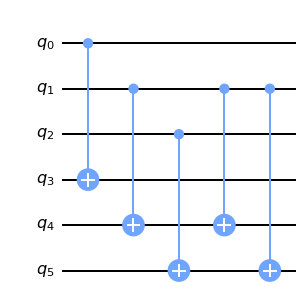

In [2]:
from qiskit import QuantumCircuit
oracle = QuantumCircuit(6, name="$U_f$")
for i in range(3):
    oracle.cx(i, i+3)
oracle.cx(1, 4)
oracle.cx(1, 5)

oracle.draw(output='mpl')

Next recall that the circuit for Simon's algorithm is the following:


![](img/simons_algorithm.png)


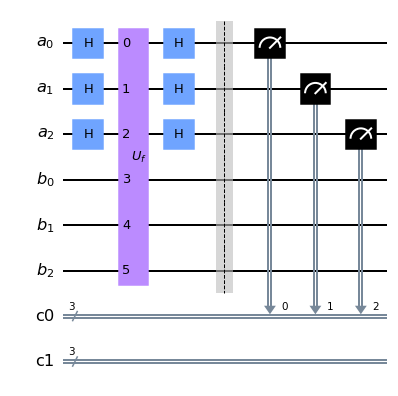

In [3]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

n = 3

qc = QuantumCircuit(QuantumRegister(3, 'a'), QuantumRegister(3, 'b'), ClassicalRegister(3), ClassicalRegister(3))


## Step 1 - hadamards
qc.h(range(n))

## Step 2 - Apply oracle
qc.append(oracle, range(2*n))

## Step 3 - hadamards
qc.h(range(n))


# Step 4 - measure
qc.barrier()
qc.measure(range(n), range(n))
#qc.measure(range(n,2*n), range(n, 2*n))

qc.draw(output='mpl')


y =  {'111', '001', '000', '110'}


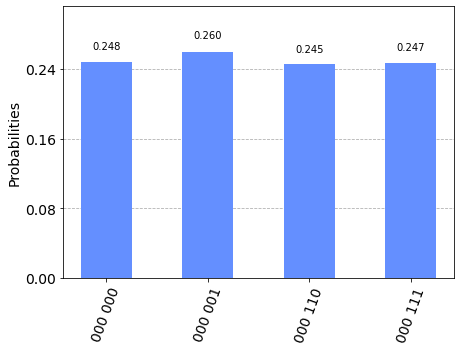

In [4]:
from qiskit import BasicAer, execute
from qiskit.visualization import plot_histogram

backend = BasicAer.get_backend("qasm_simulator")
results = execute(qc, backend, shots=1024).result().get_counts()

print("y = ", set([k[-3:] for k in results.keys()]))
plot_histogram(results)

Suppose $a = \begin{bmatrix} a_1 \\ a_2 \\ a_3 \end{bmatrix}$

Then we have the following equations:

- $\begin{bmatrix} 0 \\ 0 \\ 0 \end{bmatrix} \cdot \begin{bmatrix} a_1 \\ a_2 \\ a_3 \end{bmatrix} = \begin{bmatrix} 0 \\ 0 \\ 0 \end{bmatrix}$



- $\begin{bmatrix} 0 \\ 0 \\ 1 \end{bmatrix} \cdot \begin{bmatrix} a_1 \\ a_2 \\ a_3 \end{bmatrix} = \begin{bmatrix} 0 \\ 0 \\ 0 \end{bmatrix}$



- $\begin{bmatrix} 1 \\ 1 \\ 0 \end{bmatrix} \cdot \begin{bmatrix} a_1 \\ a_2 \\ a_3 \end{bmatrix} = \begin{bmatrix} 0 \\ 0 \\ 0 \end{bmatrix}$



- $\begin{bmatrix} 1 \\ 1 \\ 1 \end{bmatrix} \cdot \begin{bmatrix} a_1 \\ a_2 \\ a_3 \end{bmatrix} = \begin{bmatrix} 0 \\ 0 \\ 0 \end{bmatrix}$


From this we can see that a = $110$ satisfies all 4 equations. Very nice!

## Quantum Fourier Transform (QFT)

Next, we'll consider the qft and how to implement it in qiskit.

Recall the circuit:

![](img/qft-circuit2.png)

To build this in qiskit, we can just cheat and use the circuit library!

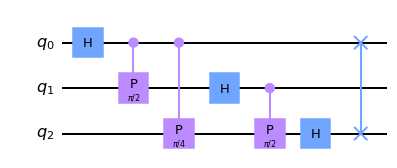

In [5]:
from qiskit.circuit.library import QFT

qc = QFT(3) # just give the number of qubits.
qc.draw(output='mpl')

Note that the gate being used is $P(\lambda) = \begin{bmatrix} 1 & 0\\ 1 & e^{i\lambda} \end{bmatrix}$

(https://qiskit.org/documentation/stubs/qiskit.circuit.library.PhaseGate.html)

Next let's see what these states look like for different inputs

Here's a helper function to perform qft on a custom state:

In [6]:
def prepare_input(x):
    n = len(x)
    qc = QuantumCircuit(n)
    for i, y in enumerate(x):
        if y == "1": qc.x(i)
            
    return qc

def qft_input(x='000', n=3):
    qc = QuantumCircuit(n)
    
    qc += prepare_input(x)
    
    qc.barrier()
    
    qc += QFT(n)
    
    return qc

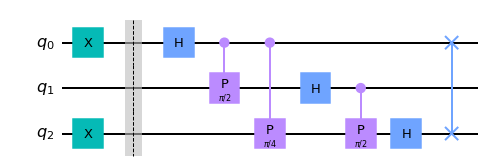

In [7]:
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_state_qsphere, plot_bloch_multivector
qc = qft_input('101')
qc.draw(output='mpl')

Here's a snazzy interactive widget which lets us plot $QFT|x\rangle$ for any $x$ we like. In particular, it helps visualize the effect of these binary fractions. 

In [8]:
%matplotlib inline
# %matplotlib widget #to make even more interactive (and more buggy)

from ipywidgets import *
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")

n = 3

def frac_sum(x):
    s = 0
    for i in range(len(x)):
        s += int(x[i])/2**(i+1)
    return s

def update(x=0):
    y = format(x, '03b') #Turns the string to binary
    print("x =", x, "\t=> j1j2j3 =", y)
    s = "j1j2j3"
    for i in range(n)[::-1]:
        print("0." + s[2*i:], "=", frac_sum(y[i:]), end=",\t") #Prints all the binary fractions for q_0, then q_1, ...
    qc = prepare_input(y)
    state1 = Statevector.from_instruction(qc)  
    
    qc = qft_input(y)
    state2 = Statevector.from_instruction(qc)
    
    display(plot_bloch_multivector(state1), plot_bloch_multivector(state2)) #plots the input state and then qft state below
    


interact(update, x= widgets.IntSlider(value=0, min=0, max=2**n - 1, step=1));

interactive(children=(IntSlider(value=0, description='x', max=7), Output()), _dom_classes=('widget-interact',)…